In [1]:
# ============================
# Title & Environment
# ============================
"""
Amazon Music Clustering — Complete Notebook
Follow the cells in order. Save this notebook as amazon_music_clustering.ipynb

Reference: Project spec (provided). :contentReference[oaicite:1]{index=1}
"""
# For reproducibility and clean plotting
import os
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
# ============================
# Imports
# ============================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

import joblib

In [3]:
# ============================
# Utility functions
# ============================
def show_df_info(df, name="DataFrame"):
    print(f"--- {name} shape: {df.shape} ---")
    display(df.head())
    print(df.info())
    print("\nMissing values per column:\n", df.isnull().sum())

def plot_numeric_distributions(df, cols, figsize=(14, 6)):
    plt.figure(figsize=figsize)
    df[cols].hist(bins=30, layout=(int(np.ceil(len(cols)/5)), 5))
    plt.tight_layout()
    plt.show()

def save_csv(df, filename):
    path = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(path, index=False)
    print(f"Saved: {path}")

def elbow_plot(X_scaled, k_range=range(2, 11)):
    sse = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        km.fit(X_scaled)
        sse.append(km.inertia_)
    plt.figure(figsize=(8,4))
    plt.plot(list(k_range), sse, marker='o')
    plt.xticks(list(k_range))
    plt.xlabel("k (number of clusters)")
    plt.ylabel("SSE (Inertia)")
    plt.title("Elbow Method for choosing k")
    plt.grid(True)
    plt.show()
    return sse

def silhouette_scores_plot(X_scaled, k_range=range(2,11)):
    sil_scores = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        sil_scores[k] = sil
        print(f"k={k} -> silhouette score = {sil:.4f}")
    ks = list(sil_scores.keys())
    vals = list(sil_scores.values())
    plt.figure(figsize=(8,4))
    plt.plot(ks, vals, marker='o')
    plt.xlabel("k")
    plt.ylabel("Silhouette score")
    plt.title("Silhouette scores by k")
    plt.grid(True)
    plt.show()
    return sil_scores

In [4]:
# ============================
# Load Dataset
# ============================
# Replace the filename with your CSV path if it's different
DATA_PATH = "single_genre_artists.csv"
df_raw = pd.read_csv(DATA_PATH)
show_df_info(df_raw, "Raw dataset")

--- Raw dataset shape: (95837, 23) ---


,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.184,4,...,0.993,0.000016,0.325,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.180,10,...,0.989,0.000000,0.128,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.206,0,...,0.995,0.000000,0.418,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.467,9,...,0.991,0.000000,0.219,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.298,9,...,0.991,0.000000,0.373,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness    95837 non-null  float64
 15  liveness            95837 non-null  float64
 16  vale

In [5]:
# ============================
# Quick Cleaning
# ============================
# Drop exact duplicates
df_raw.drop_duplicates(inplace=True)
print("After dropping duplicates:", df_raw.shape)

# Drop rows with all-nulls (rare)
df_raw.dropna(how='all', inplace=True)

After dropping duplicates: (95837, 23)


In [6]:
# ============================
# Feature Selection
# ============================
features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
]

# Verify these columns exist
missing_cols = [c for c in features if c not in df_raw.columns]
if missing_cols:
    raise ValueError(f"Missing expected feature columns: {missing_cols}")

# Keep reference columns for later interpretation
meta_cols = ['track_id', 'track_name', 'artist_name']
existing_meta = [c for c in meta_cols if c in df_raw.columns]

df = df_raw[existing_meta + features].copy()
show_df_info(df, "Selected features + metadata")

--- Selected features + metadata shape: (95837, 10) ---


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.563,0.184,-13.757,0.0512,0.993,0.000016,0.325,0.654,133.088,161427
1,0.427,0.180,-15.375,0.0670,0.989,0.000000,0.128,0.431,78.459,223440
2,0.511,0.206,-15.514,0.0592,0.995,0.000000,0.418,0.481,70.443,208267
3,0.676,0.467,-12.393,0.1650,0.991,0.000000,0.219,0.726,129.775,161933
4,0.650,0.298,-13.806,0.1380,0.991,0.000000,0.373,0.844,75.950,167973


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      95837 non-null  float64
 1   energy            95837 non-null  float64
 2   loudness          95837 non-null  float64
 3   speechiness       95837 non-null  float64
 4   acousticness      95837 non-null  float64
 5   instrumentalness  95837 non-null  float64
 6   liveness          95837 non-null  float64
 7   valence           95837 non-null  float64
 8   tempo             95837 non-null  float64
 9   duration_ms       95837 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 7.3 MB
None

Missing values per column:
 danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64


In [7]:
# ============================
# Handle Missing Values
# ============================
# Check missingness
print(df[features].isnull().sum())

# Strategy (brutal, honest): drop rows with missing audio features (safe for this dataset size).
# If too many rows lost, switch to imputation (median).
num_missing = df[features].isnull().any(axis=1).sum()
print(f"Rows with any missing audio features: {num_missing}")

if num_missing > 0:
    # Quick approach: drop
    df = df.dropna(subset=features).reset_index(drop=True)
    print("Dropped rows with missing audio features. New shape:", df.shape)


danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64
Rows with any missing audio features: 0


In [8]:
# ============================
# Exploratory Data Analysis (EDA)
# ============================
# Summary stats
display(df[features].describe().T)

,count,mean,std,min,25%,50%,75%,max
danceability,95837.0,0.586853,0.155422,0.00000,0.4880,0.605000,0.7000,0.991
energy,95837.0,0.541083,0.236304,0.00002,0.3650,0.542000,0.7270,1.000
loudness,95837.0,-10.157862,4.748798,-50.17400,-12.7230,-9.397000,-6.6920,5.376
speechiness,95837.0,0.168832,0.275417,0.00000,0.0341,0.046200,0.1030,0.968
acousticness,95837.0,0.458989,0.330416,0.00000,0.1330,0.453000,0.7590,0.996
instrumentalness,95837.0,0.082145,0.232440,0.00000,0.0000,0.000004,0.0013,1.000
liveness,95837.0,0.224916,0.185829,0.00000,0.1000,0.149000,0.3020,0.997
valence,95837.0,0.574281,0.248126,0.00000,0.3780,0.589000,0.7800,1.000
tempo,95837.0,117.539870,30.190399,0.00000,94.8290,116.595000,135.9750,239.906
duration_ms,95837.0,208732.031835,117752.555950,6373.00000,157333.0000,204000.000000,250267.0000,4800118.000


<Figure size 1400x600 with 0 Axes>

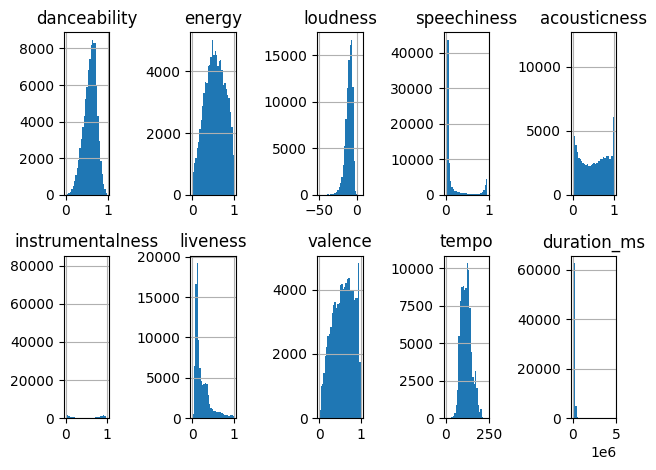

In [9]:
# Distribution plots
plot_numeric_distributions(df, features)

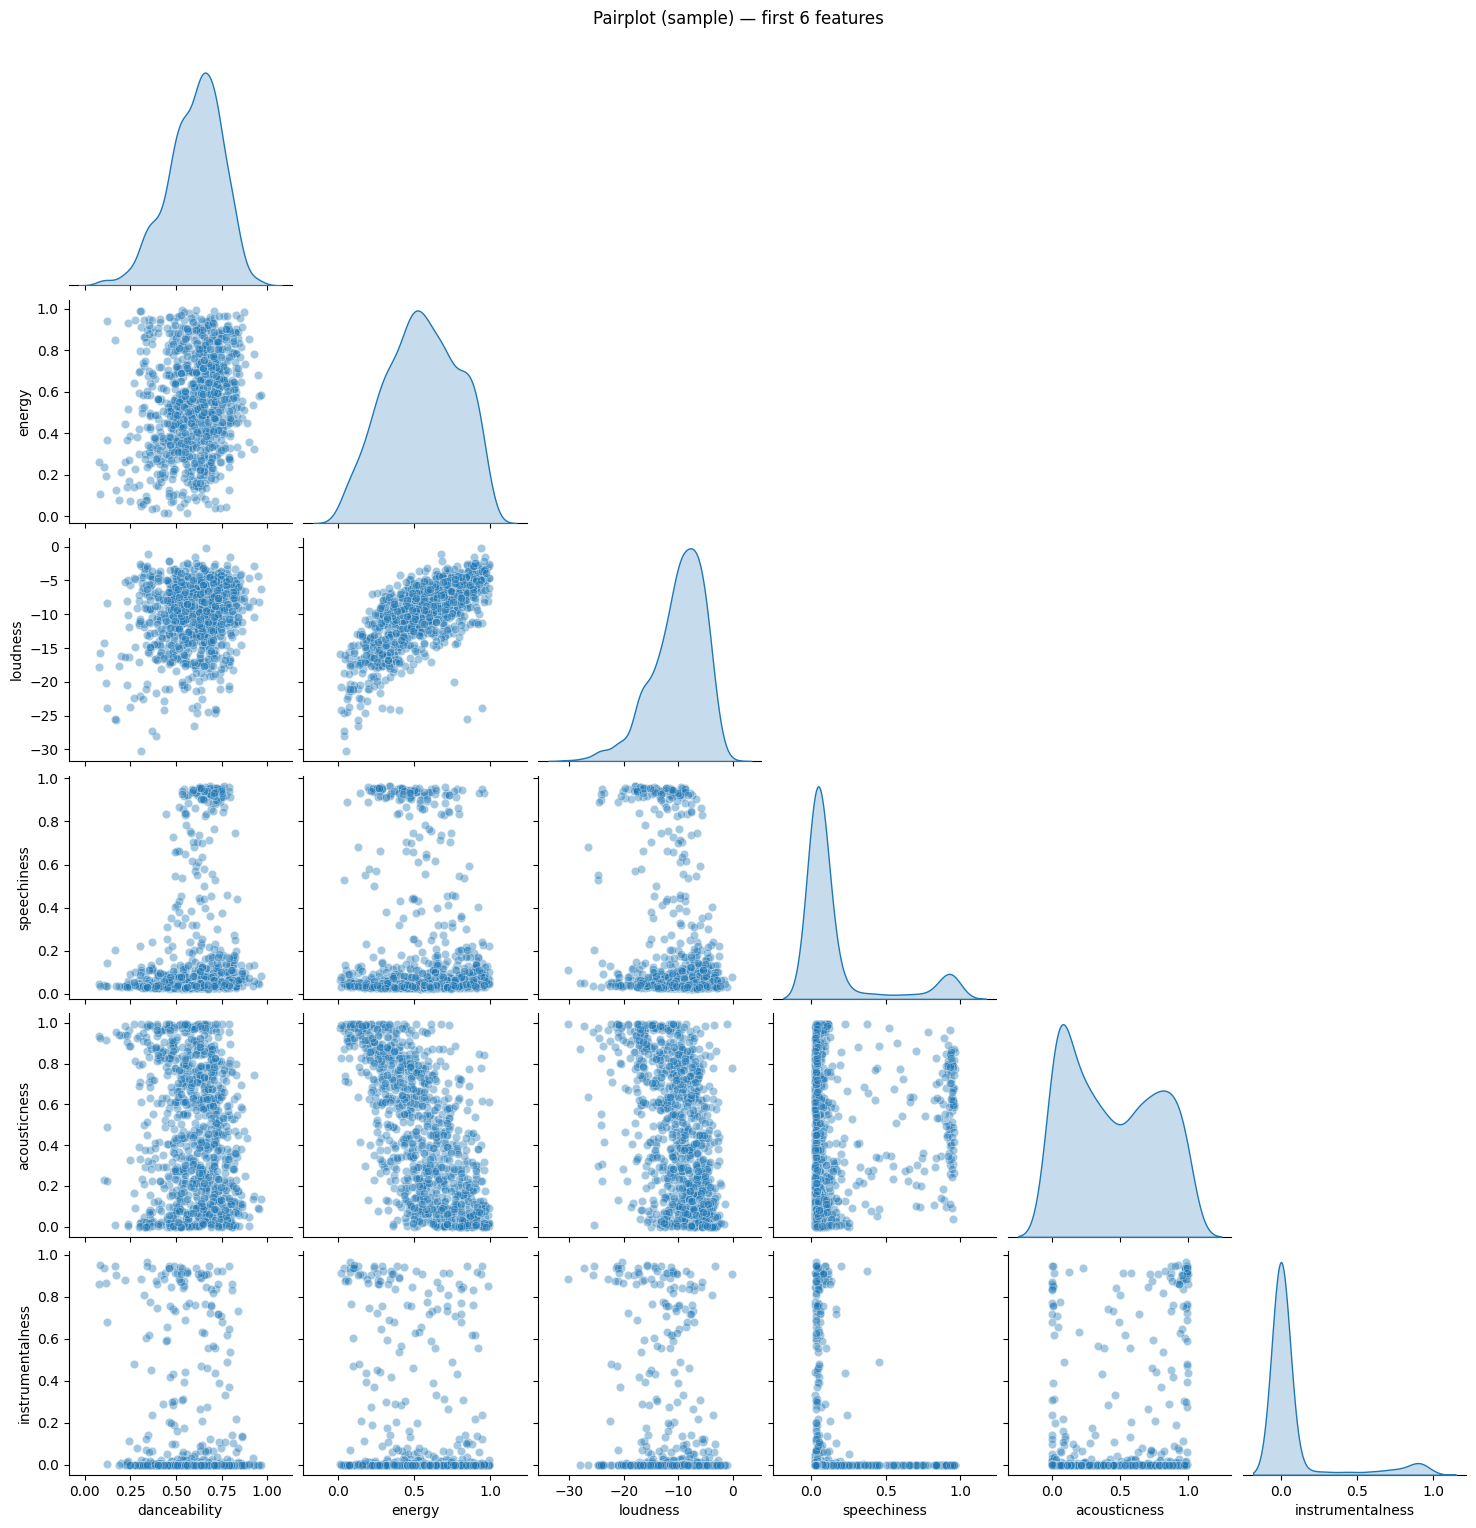

In [10]:
# Pairplot (sample for speed)
sample = df[features].sample(n=min(1000, df.shape[0]), random_state=RANDOM_STATE)
sns.pairplot(sample.iloc[:, :6], corner=True, diag_kind='kde', plot_kws={'alpha':0.4})
plt.suptitle("Pairplot (sample) — first 6 features", y=1.02)
plt.show()

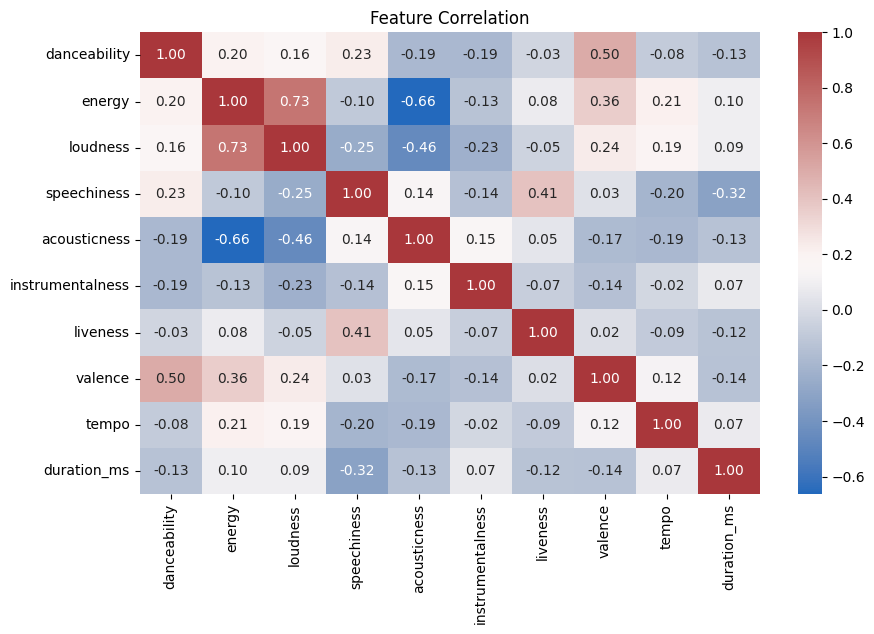

In [11]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[features].corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Feature Correlation")
plt.show()

In [12]:
# ============================
# Scaling
# ============================
# StandardScaler is recommended; MinMaxScaler is an alternative
scaler = StandardScaler()
X = df[features].values
X_scaled = scaler.fit_transform(X)

# Save scaler for later use
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.joblib"))
print("Scaler saved.")

Scaler saved.


In [14]:
# ===== quick k search + final KMeans =====
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import time

RANDOM_STATE = 42
start_time = time.time()

# 1) Quick PCA to reduce dimensionality for fast search
pca_n = min(5, X_scaled.shape[1])   # keep <=5 components
pca = PCA(n_components=pca_n, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA -> {X_pca.shape}, explained_var_sum={pca.explained_variance_ratio_.sum():.3f}")

# 2) Fast search with MiniBatchKMeans and sampled silhouette
def fast_search(X, k_list, sample_size=3000):
    results = {}
    n = X.shape[0]
    sample_size = min(sample_size, n)
    for k in k_list:
        mbk = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE,
                              n_init=5, max_iter=200, batch_size=1024)
        labels = mbk.fit_predict(X)
        inertia = mbk.inertia_
        try:
            sil = silhouette_score(X, labels, sample_size=sample_size, random_state=RANDOM_STATE)
        except Exception:
            sil = float('nan')
        try:
            dbi = davies_bouldin_score(X, labels)
        except Exception:
            dbi = float('nan')
        results[k] = {"inertia": inertia, "silhouette": sil, "dbi": dbi}
        print(f"k={k}  inertia={inertia:.1f}  silhouette~={sil:.4f}  dbi={dbi:.4f}")
    return results

# 3) Coarse then refine strategy
coarse = list(range(2, 11, 2))   # [2,4,6,8,10]
print("\n-- Coarse search --")
coarse_res = fast_search(X_pca, coarse, sample_size=3000)

best_coarse = max(coarse_res, key=lambda k: coarse_res[k]["silhouette"] if not np.isnan(coarse_res[k]["silhouette"]) else -1)
print("Best coarse k (approx):", best_coarse)

# refine around best_coarse
k_min = max(2, best_coarse - 2)
k_max = best_coarse + 2
refine = list(range(k_min, k_max + 1))
print("\n-- Refine search --", refine)
refine_res = fast_search(X_pca, refine, sample_size=5000)

# pick best k from combined results by silhouette (fallback to inertia)
combined = {**coarse_res, **refine_res}
best_k = max(combined, key=lambda k: combined[k]["silhouette"] if not np.isnan(combined[k]["silhouette"]) else -combined[k]["inertia"])
print(f"\nAuto-selected best_k ≈ {best_k}")

# 4) Train final KMeans on the FULL scaled feature matrix (not PCA) with reasonable n_init
print("\nTraining final KMeans on full features (this is the only heavier step):")
final_k = int(best_k)
final_km = KMeans(n_clusters=final_k, random_state=RANDOM_STATE, n_init=20, max_iter=300, algorithm='elkan')
t0 = time.time()
final_labels = final_km.fit_predict(X_scaled)
t1 = time.time()
print(f"Final KMeans trained in {t1-t0:.2f}s (k={final_k})")

# attach to df
df['cluster'] = final_labels.astype(int)

# quick final scores (silhouette on sample to save time)
try:
    final_sil = silhouette_score(X_scaled, final_labels, sample_size=min(5000, X_scaled.shape[0]), random_state=RANDOM_STATE)
except Exception:
    final_sil = float('nan')
final_dbi = davies_bouldin_score(X_scaled, final_labels) if X_scaled.shape[0] > final_k else float('nan')

print(f"\nFinal silhouette (sampled) = {final_sil:.4f}")
print(f"Final Davies-Bouldin Index = {final_dbi:.4f}")

# runtime
print(f"\nTotal time for this cell: {time.time() - start_time:.2f}s")


PCA -> (95837, 5), explained_var_sum=0.758

-- Coarse search --
k=2  inertia=596087.2  silhouette~=0.2821  dbi=1.3454
k=4  inertia=393654.6  silhouette~=0.1948  dbi=1.4661
k=6  inertia=310762.7  silhouette~=0.2378  dbi=1.3746
k=8  inertia=277758.0  silhouette~=0.1909  dbi=1.3795
k=10  inertia=243452.9  silhouette~=0.1949  dbi=1.3317
Best coarse k (approx): 2

-- Refine search -- [2, 3, 4]
k=2  inertia=596087.2  silhouette~=0.2792  dbi=1.3454
k=3  inertia=435139.4  silhouette~=0.3002  dbi=1.2859
k=4  inertia=393654.6  silhouette~=0.1967  dbi=1.4661

Auto-selected best_k ≈ 3

Training final KMeans on full features (this is the only heavier step):
Final KMeans trained in 2.85s (k=3)

Final silhouette (sampled) = 0.2412
Final Davies-Bouldin Index = 1.5705

Total time for this cell: 6.42s


In [15]:
cluster_profile = df.groupby('cluster')[features].mean().T
display(cluster_profile)

for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c} — Count:", df[df['cluster']==c].shape[0])
    display(df[df['cluster']==c][features].mean().round(3))

cluster,0,1,2
danceability,0.664259,0.486376,0.627372
energy,0.466618,0.311307,0.693677
loudness,-13.364416,-13.203705,-7.606166
speechiness,0.829938,0.060157,0.075051
acousticness,0.585916,0.749176,0.258438
instrumentalness,0.001384,0.168526,0.050698
liveness,0.435523,0.182115,0.199842
valence,0.584054,0.413258,0.666450
tempo,100.388816,111.941246,124.913029
duration_ms,97522.463081,223652.717216,226479.720252



Cluster 0 — Count: 12514


,0
danceability,0.664
energy,0.467
loudness,-13.364
speechiness,0.830
acousticness,0.586
instrumentalness,0.001
liveness,0.436
valence,0.584
tempo,100.389
duration_ms,97522.463



Cluster 1 — Count: 30815


,0
danceability,0.486
energy,0.311
loudness,-13.204
speechiness,0.060
acousticness,0.749
instrumentalness,0.169
liveness,0.182
valence,0.413
tempo,111.941
duration_ms,223652.717



Cluster 2 — Count: 52508


,0
danceability,0.627
energy,0.694
loudness,-7.606
speechiness,0.075
acousticness,0.258
instrumentalness,0.051
liveness,0.200
valence,0.666
tempo,124.913
duration_ms,226479.720


In [17]:
from sklearn.metrics import pairwise_distances_argmin_min

# Detect which metadata columns exist
possible_meta = ['track_id', 'track_name', 'artist_name']
meta_cols = [c for c in possible_meta if c in df.columns]

print("Metadata columns found:", meta_cols)

# Get centroids
centroids = final_km.cluster_centers_
closest, distances = pairwise_distances_argmin_min(centroids, X_scaled)

rep_rows = []
for i, idx in enumerate(closest):
    row = df.iloc[idx]
    row_dict = row[meta_cols + ['cluster']].to_dict() if meta_cols else {'cluster': row['cluster']}
    rep_rows.append(row_dict)

rep_df = pd.DataFrame(rep_rows)
display(rep_df)

rep_df.to_csv("representative_tracks_by_cluster.csv", index=False)
print("Saved representative tracks file.")


Metadata columns found: []


,cluster
0,0.0
1,1.0
2,2.0


Saved representative tracks file.


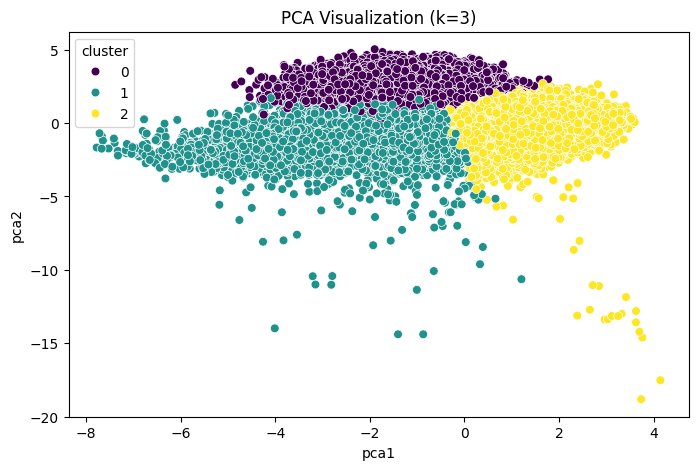

In [18]:
pca_vis = PCA(n_components=2, random_state=42)
pca_vals = pca_vis.fit_transform(X_scaled)

df['pca1'] = pca_vals[:,0]
df['pca2'] = pca_vals[:,1]

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='viridis', s=40)
plt.title(f"PCA Visualization (k={df.cluster.nunique()})")
plt.show()

In [19]:
df.to_csv("amazon_music_clusters_final.csv", index=False)
print("Saved final CSV.")

Saved final CSV.
